Tugas

Prosedur pelatihan pada praktikum 2 merupakan prosedur sederhana, yang tidak memberi Anda banyak kendali. Model ini menggunakan "teacher-forcing" yang mencegah prediksi buruk diumpankan kembali ke model, sehingga model tidak pernah belajar untuk pulih dari kesalahan. Jadi, setelah Anda melihat cara menjalankan model secara manual, selanjutnya Anda akan mengimplementasikan custom loop pelatihan. Hal ini memberikan titik awal jika, misalnya, Anda ingin menerapkan pembelajaran kurikulum untuk membantu menstabilkan keluaran open-loop model. Bagian terpenting dari loop pelatihan khusus adalah fungsi langkah pelatihan.

Gunakan [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) untuk men track nilai gradient. Anda dapat mempelajari lebih lanjut tentang pendekatan ini dengan membaca [eager execution guide](https://www.tensorflow.org/guide/eager).

Prosedurnya adalah "

- Jalankan Model dan hitung loss dengan [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape).
- Hitung update dan terapkan pada model dengan optimizer

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
    inputs, labels = inputs
    with tf.GradientTape() as tape:
        predictions = self(inputs, training=True)
        loss = self.loss(labels, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return {'loss': loss}

Kode diatas menerapkan train_step method sesuai dengan  [Keras' train_step conventions](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit). Ini opsional, tetapi memungkinkan Anda mengubah perilaku langkah pelatihan dan tetap menggunakan keras [Model.compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) and [Model.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) methods.

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

Atau jika ingin lebih mengetahui dalamnya, kita bisa membuat custom training loop sendiri:

In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?

**answer :**

In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I have been a fervent Hal Hartley supporter since I saw his short "Surviving Desire" in high school, and even then was still completely unmoored by his searingly brilliant "Henry Fool." But this 10-year-later sequel is not only unnecessary, it\'s disgraceful.<br /><br />After a choppy and expeditious start, "Fay Grim" devolves into pseudo-intellectualism, flat out boredom, and finally unwarranted - and unwanted - nihilism. And that\'s just the plot.<br /><br />The majority of the new faces are as frivolous and poorly-developed as the movie: one particularly flat character ends up hogging half the time we spend with the infamous Henry Fool himself, and it\'s his only spoken scene in the film!<br /><br />Jeff Goldblum\'s Agent Fulbright, it seems, is the only bright character (a pun surely intended by Hartley as well). How, then, is he left? **SPOILER** Dead via a car bombing, easily making this the gentle-natured Hartley\'s most violent film to date, and tonally all wrong in 

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,  26,  75, ...,   0,   0,   0],
       [ 56,   1, 465, ...,   0,   0,   0],
       [724,   1,   7, ...,   0,   0,   0]], dtype=int64)

In [10]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I have been a fervent Hal Hartley supporter since I saw his short "Surviving Desire" in high school, and even then was still completely unmoored by his searingly brilliant "Henry Fool." But this 10-year-later sequel is not only unnecessary, it\'s disgraceful.<br /><br />After a choppy and expeditious start, "Fay Grim" devolves into pseudo-intellectualism, flat out boredom, and finally unwarranted - and unwanted - nihilism. And that\'s just the plot.<br /><br />The majority of the new faces are as frivolous and poorly-developed as the movie: one particularly flat character ends up hogging half the time we spend with the infamous Henry Fool himself, and it\'s his only spoken scene in the film!<br /><br />Jeff Goldblum\'s Agent Fulbright, it seems, is the only bright character (a pun surely intended by Hartley as well). How, then, is he left? **SPOILER** Dead via a car bombing, easily making this the gentle-natured Hartley\'s most violent film to date, and tonally all wrong i

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [12]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [13]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 6s 6s/step
[0.00398385]


In [14]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 387ms/step
[0.00398385]


In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [19]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)
# this probably take 2 hours or less to get it done, make it 2 epochs

Epoch 1/10


391/391 [==============================] - 904s 2s/step - loss: 0.4881 - accuracy: 0.7686 - val_loss: 0.4228 - val_accuracy: 0.8229
Epoch 2/10
391/391 [==============================] - 921s 2s/step - loss: 0.3895 - accuracy: 0.8320 - val_loss: 0.3667 - val_accuracy: 0.8469
Epoch 3/10
391/391 [==============================] - 908s 2s/step - loss: 0.3468 - accuracy: 0.8497 - val_loss: 0.3456 - val_accuracy: 0.8578
Epoch 4/10
391/391 [==============================] - 1098s 3s/step - loss: 0.3280 - accuracy: 0.8591 - val_loss: 0.3403 - val_accuracy: 0.8458
Epoch 5/10
391/391 [==============================] - 866s 2s/step - loss: 0.3170 - accuracy: 0.8652 - val_loss: 0.3265 - val_accuracy: 0.8583
Epoch 6/10
391/391 [==============================] - 914s 2s/step - loss: 0.3092 - accuracy: 0.8703 - val_loss: 0.3212 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 903s 2s/step - loss: 0.3036 - accuracy: 0.8698 - val_loss: 0.3211 - val_accuracy: 0.8641
Epoch 8/1

In [20]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 129s 330ms/step - loss: 0.3154 - accuracy: 0.8626
Test Loss: 0.31536927819252014
Test Accuracy: 0.862559974193573


(0.0, 0.497666634619236)

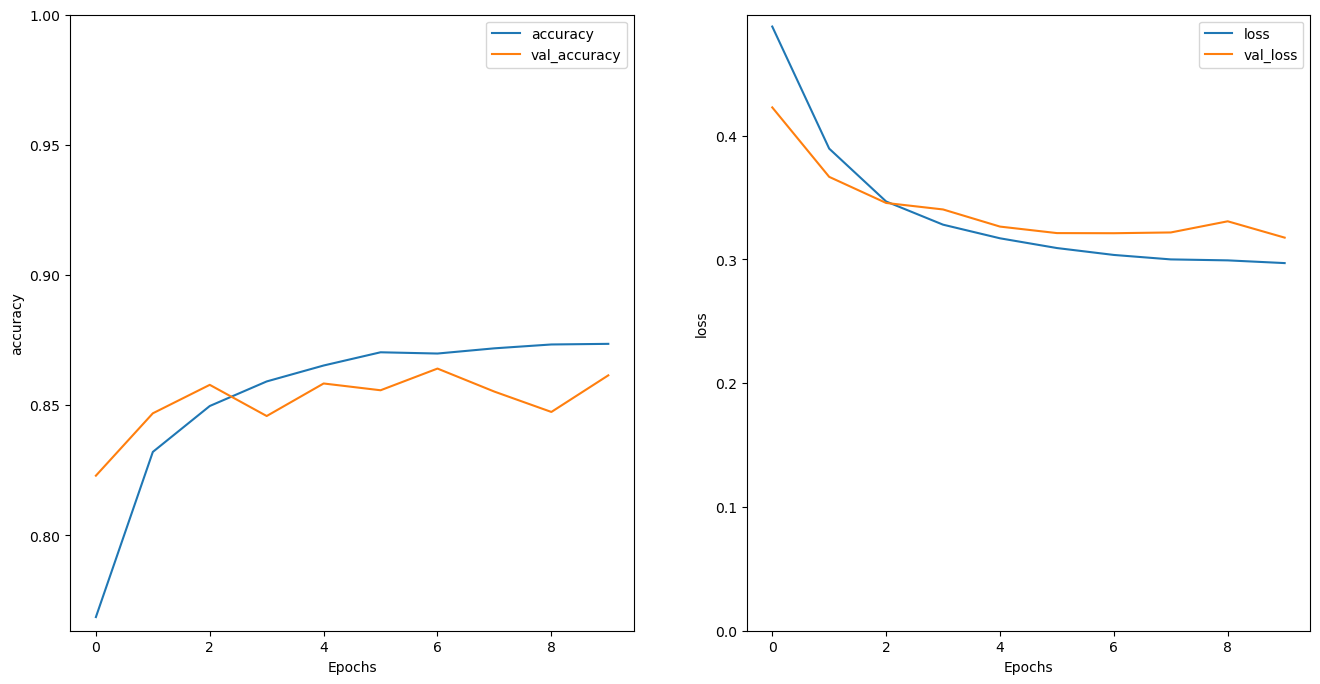

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [22]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 5s 5s/step


In [23]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['accuracy'])

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 302s 742ms/step - loss: 0.6931 - accuracy: 0.5000
Test Loss: 0.6931031942367554
Test Accuracy: 0.5


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-0.00421111]]


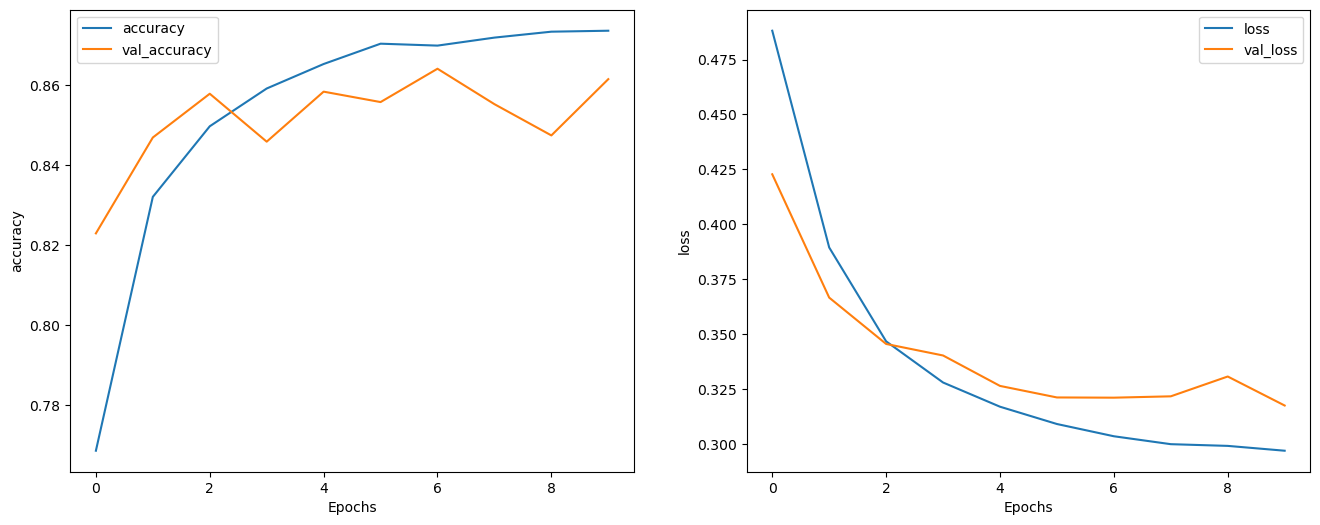

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [28]:
import tensorflow as tf
import numpy as np
import os
import time

In [29]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [30]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [31]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [32]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [33]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [34]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)

In [35]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [36]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [37]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [38]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [39]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [40]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1], dtype=int64)>

In [41]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [42]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [43]:
seq_length = 100

In [44]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [45]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [46]:
def split_input_target(sequence):   
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [47]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [48]:
dataset = sequences.map(split_input_target)

In [49]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [50]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [51]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [52]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [53]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [54]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [55]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [57]:
sampled_indices

array([59, 14, 49, 20, 27, 48, 13, 37, 33, 15, 44,  8,  5,  6, 45, 29, 63,
       47,  8, 26, 39, 53, 10, 65, 60, 52, 52, 58, 22, 63, 57, 65, 40, 41,
        8, 30,  8, 63, 31, 48, 13, 24, 37, 25,  5,  1, 42, 57, 37, 16, 41,
        2, 37, 43, 33, 41, 60, 54, 48, 52,  1,  3, 28,  2, 12,  2, 24, 19,
       30, 38, 55, 33, 27, 31, 56, 61, 48, 60, 34, 35, 61, 43, 56, 43,  8,
        8, 30,  6, 15, 65, 55, 40, 61, 40, 21, 26, 46, 17, 29, 52],
      dtype=int64)

In [58]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'ing annoyance to the treacherous feet\nWhich with usurping steps do trample thee:\nYield stinging nett'

Next Char Predictions:
 b"tAjGNi?XTBe-&'fPxh-MZn3zummsIxrzab-Q-xRi?KXL&\ncrXCb XdTbuoim\n!O ; KFQYpTNRqviuUVvdqd--Q'BzpavaHMgDPm"


In [59]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [60]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1887746, shape=(), dtype=float32)


In [61]:
tf.exp(example_batch_mean_loss).numpy()

65.94193

In [62]:
model.compile(optimizer='adam', loss=loss)

In [63]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [65]:
EPOCHS = 10

In [66]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
172/172 [==============================] - 385s 2s/step - loss: 2.7197
Epoch 2/10
172/172 [==============================] - 388s 2s/step - loss: 1.9914
Epoch 3/10
172/172 [==============================] - 386s 2s/step - loss: 1.7159
Epoch 4/10
172/172 [==============================] - 395s 2s/step - loss: 1.5523
Epoch 5/10
172/172 [==============================] - 392s 2s/step - loss: 1.4522
Epoch 6/10
172/172 [==============================] - 393s 2s/step - loss: 1.3830
Epoch 7/10
172/172 [==============================] - 397s 2s/step - loss: 1.3294
Epoch 8/10
172/172 [==============================] - 394s 2s/step - loss: 1.2846
Epoch 9/10
172/172 [==============================] - 395s 2s/step - loss: 1.2439
Epoch 10/10
172/172 [==============================] - 393s 2s/step - loss: 1.2036


In [67]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
    inputs, labels = inputs
    with tf.GradientTape() as tape:
        predictions = self(inputs, training=True)
        loss = self.loss(labels, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return {'loss': loss}

In [68]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [69]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [71]:
model.fit(dataset, epochs=10)

Epoch 1/10


172/172 [==============================] - 483s 3s/step - loss: 2.6765
Epoch 2/10
172/172 [==============================] - 537s 3s/step - loss: 1.9658
Epoch 3/10
172/172 [==============================] - 537s 3s/step - loss: 1.6886
Epoch 4/10
172/172 [==============================] - 528s 3s/step - loss: 1.5313
Epoch 5/10
172/172 [==============================] - 511s 3s/step - loss: 1.4365
Epoch 6/10
172/172 [==============================] - 502s 3s/step - loss: 1.3697
Epoch 7/10
172/172 [==============================] - 607s 4s/step - loss: 1.3185
Epoch 8/10
172/172 [==============================] - 799s 5s/step - loss: 1.2742
Epoch 9/10
172/172 [==============================] - 778s 5s/step - loss: 1.2335
Epoch 10/10
172/172 [==============================] - 726s 4s/step - loss: 1.1935


In [72]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 1.1086
Epoch 1 Batch 50 Loss 1.1253
Epoch 1 Batch 100 Loss 1.1459
Epoch 1 Batch 150 Loss 1.1486

Epoch 1 Loss: 1.1527
Time taken for 1 epoch 513.37 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.1007
Epoch 2 Batch 50 Loss 1.0859
Epoch 2 Batch 100 Loss 1.1388
Epoch 2 Batch 150 Loss 1.1399

Epoch 2 Loss: 1.1108
Time taken for 1 epoch 455.48 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.0302
Epoch 3 Batch 50 Loss 1.0712
Epoch 3 Batch 100 Loss 1.0543
Epoch 3 Batch 150 Loss 1.0945

Epoch 3 Loss: 1.0674
Time taken for 1 epoch 515.84 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 0.9929
Epoch 4 Batch 50 Loss 1.0186
Epoch 4 Batch 100 Loss 1.0362
Epoch 4 Batch 150 Loss 1.0607

Epoch 4 Loss: 1.0200
Time taken for 1 epoch 517.97 sec
_________________________________________________________________